In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
# imports

from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Clifford, Operator, StabilizerState, Statevector
from qiskit.transpiler import CouplingMap

from synthesis.sat_problem_clifford import SatProblemClifford
from synthesis.utils import line_coupling_map
from synthesis.synthesize import synthesize_optimal
from synthesis.synthesize_clifford import synthesize_clifford_depth2q

<IPython.core.display.Latex object>

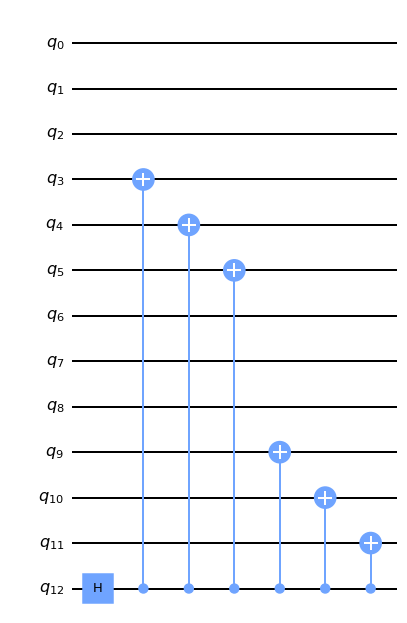

In [55]:
# naive preparation of the state of interest (does not adhere to LNN connectivity)

nq = 13  # number of qubits
k = 3  # number of consequtive ones (0: GHZ, 1: checkerboard, n/2: hartree-fock)
ones = [i for m in range(1, int(nq / k), 2) for i in range(m * k, (m + 1) * k)]
qc = QuantumCircuit(nq)
qc.h(nq - 1)
for target in ones:
    qc.cx(nq - 1, target)

display(Statevector(qc).draw("latex"))
qc.draw("mpl")

Looking for solution with target depth 0
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 1547,  #clauses = 12233,  #assumptions = 0
 => sat-solver result: unsat in 3.2 s
 => synthesis problem result: no solutions in 3.2 s 
Looking for solution with target depth 1
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 2963,  #clauses = 22851,  #assumptions = 0
 => sat-solver result: unsat in 6.32 s
 => synthesis problem result: no solutions in 6.32 s 
Looking for solution with target depth 2
 => synthesis problem has 5 layers
 => running sat-solver: #vars = 4379,  #clauses = 33505,  #assumptions = 0
 => sat-solver result: unsat in 9.27 s
 => synthesis problem result: no solutions in 9.27 s 
Looking for solution with target depth 3
 => synthesis problem has 7 layers
 => running sat-solver: #vars = 5795,  #clauses = 44159,  #assumptions = 0
 => sat-solver result: unsat in 12.71 s
 => synthesis problem result: no solutions in 12.71 s 
Looking for solution wit

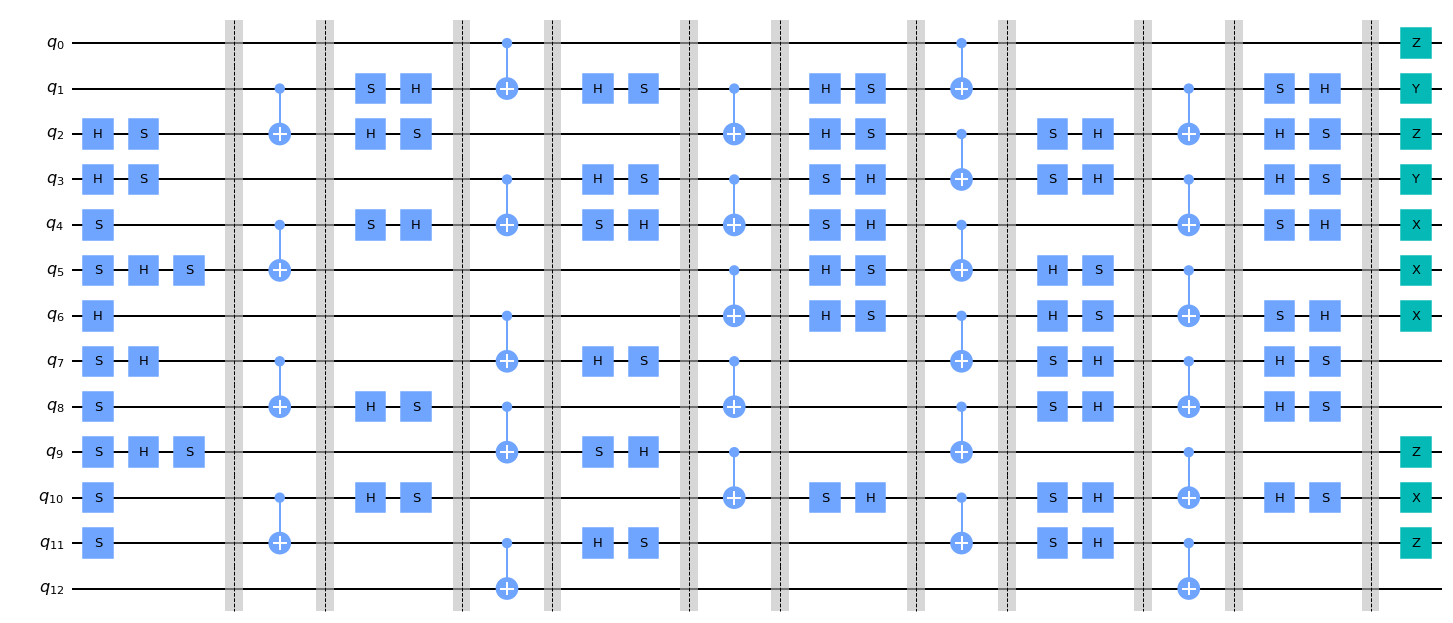

In [67]:
# prepackaged clifford synthesis routine

cliff = Clifford(qc)
res = synthesize_clifford_depth2q(
    cliff, coupling_map=line_coupling_map(cliff.num_qubits), state_preparation_mode=True
)
res.circuit.draw("mpl", fold=-1)

In [63]:
# Create a custom problem: we want to use a single H-gate in the first layer and only CX-gates after that


def create_problem_custom(cliff, depth):
    nq = cliff.num_qubits
    sat_problem = SatProblemClifford(nq, verbosity=1)
    sat_problem.set_init_matrix_to_identity(nq)
    sat_problem.set_final_clifford(cliff)
    sat_problem.set_state_preparation_mode(True)
    sat_problem.add_layer(gates=["H"], coupling_maps=[])
    for _ in range(depth):
        sat_problem.add_layer(gates=["CX"], coupling_maps=[line_coupling_map(nq)])
    return sat_problem


def synthesize_clifford_custom(cliff):
    res = synthesize_optimal(
        target_obj=cliff, create_sat_problem_fn=create_problem_custom, verbosity=1
    )
    return res.circuit

Looking for solution with target depth 0
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 1430,  #clauses = 3900,  #assumptions = 0
 => sat-solver result: unsat in 0.89 s
 => synthesis problem result: no solutions in 0.89 s 
Looking for solution with target depth 1
 => synthesis problem has 2 layers
 => running sat-solver: #vars = 2187,  #clauses = 12913,  #assumptions = 0
 => sat-solver result: unsat in 3.54 s
 => synthesis problem result: no solutions in 3.54 s 
Looking for solution with target depth 2
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 2944,  #clauses = 21926,  #assumptions = 0
 => sat-solver result: unsat in 6.13 s
 => synthesis problem result: no solutions in 6.13 s 
Looking for solution with target depth 3
 => synthesis problem has 4 layers
 => running sat-solver: #vars = 3701,  #clauses = 30939,  #assumptions = 0
 => sat-solver result: unsat in 8.85 s
 => synthesis problem result: no solutions in 8.85 s 
Looking for solution with

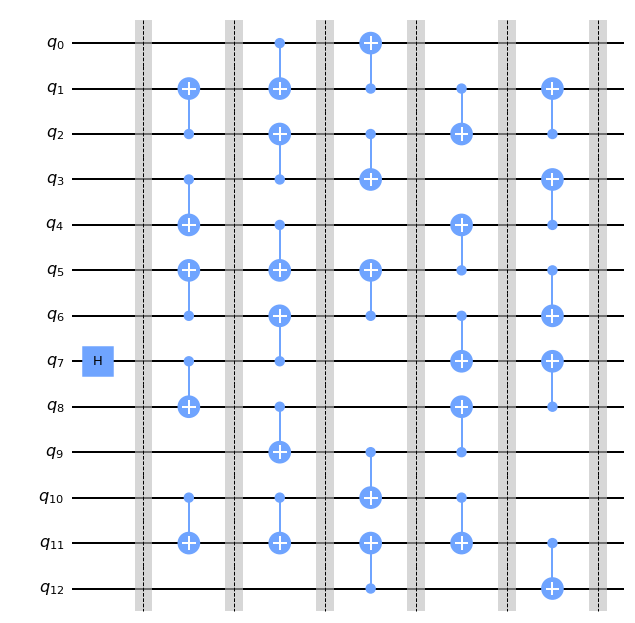

In [66]:
cliff = Clifford(qc)
circuit = synthesize_clifford_custom(cliff)
circuit.draw("mpl", fold=-1)

Looking for solution with target depth 0
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 1430,  #clauses = 3900,  #assumptions = 0
 => sat-solver result: unsat in 0.79 s
 => synthesis problem result: no solutions in 0.79 s 
Looking for solution with target depth 1
 => synthesis problem has 2 layers
 => running sat-solver: #vars = 2187,  #clauses = 12913,  #assumptions = 0
 => sat-solver result: unsat in 3.15 s
 => synthesis problem result: no solutions in 3.15 s 
Looking for solution with target depth 2
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 2944,  #clauses = 21926,  #assumptions = 0
 => sat-solver result: unsat in 5.76 s
 => synthesis problem result: no solutions in 5.76 s 
Looking for solution with target depth 3
 => synthesis problem has 4 layers
 => running sat-solver: #vars = 3782,  #clauses = 31246,  #assumptions = 0
 => sat-solver result: unsat in 8.21 s
 => synthesis problem result: no solutions in 8.21 s 
Looking for solution with

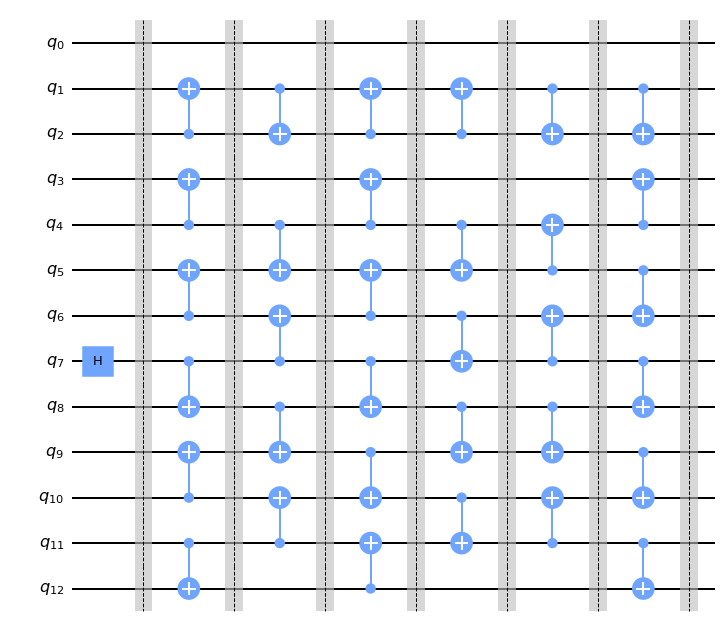

In [69]:
# let's say we also want at most 2 unique layers


def create_problem_custom_u(cliff, depth):
    nq = cliff.num_qubits
    sat_problem = SatProblemClifford(nq, verbosity=1)
    sat_problem.set_init_matrix_to_identity(nq)
    sat_problem.set_final_clifford(cliff)
    sat_problem.set_state_preparation_mode(True)
    sat_problem.add_layer(gates=["H"], coupling_maps=[])
    two_qubit_layers = []
    for _ in range(depth):
        layer = sat_problem.add_layer(
            gates=["CX"], coupling_maps=[line_coupling_map(nq)]
        )
        two_qubit_layers.append(layer)
    sat_problem.add_max_unique_layers_constraint(two_qubit_layers, 2)
    return sat_problem


def synthesize_clifford_custom_u(cliff):
    res = synthesize_optimal(
        target_obj=cliff, create_sat_problem_fn=create_problem_custom_u, verbosity=1
    )
    return res.circuit


circuit = synthesize_clifford_custom_u(cliff)
circuit.draw("mpl", fold=-1)